In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 14s 0us/step


In [0]:
x_train.shape

(50000, 40, 40, 3)

In [0]:
import os
from os import listdir
from os.path import join
 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
 
 
 
 
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
 
def save_tf_records(x_train, y_train, out_path):
    writer = tf.python_io.TFRecordWriter(out_path)
 
    for i in range(y_train.shape[0]):
   
        example = tf.train.Example(features=tf.train.Features(
            feature={'image': _bytes_feature(x_train[i].tostring()),
                     'labels': _bytes_feature(
                         y_train[i].tostring())
                     }))
 
        writer.write(example.SerializeToString())
 
    writer.close()

In [0]:
save_tf_records(x_train, y_train, './training.tf_records')

In [0]:
def load_tf_records(path):
    dataset = tf.data.TFRecordDataset(path)
 
    def parser(record):
        featdef = {
            'image': tf.FixedLenFeature(shape=[], dtype=tf.string),
            'labels': tf.FixedLenFeature(shape=[], dtype=tf.string),
        }
 
        example = tf.parse_single_example(record, featdef)
        im = tf.decode_raw(example['image'], tf.float32)
        im = tf.reshape(im, (-1, 40, 40, 3))
        lbl = tf.decode_raw(example['labels'], tf.int64)
        return im, lbl
 
    dataset = dataset.map(parser)
    #dataset = dataset.shuffle(buffer_size=50000)
    dataset = dataset.batch(50000)
    dataset = dataset.repeat(1)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [0]:
x_train,y_train = load_tf_records('./training.tf_records')




Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
x_train.shape

TensorShape([Dimension(50000), Dimension(1), Dimension(40), Dimension(40), Dimension(3)])

### Implementing Cutout###uiheudjh#tTsa

In [0]:



def cutout(img,prob=50,size=16,min_size=5,use_fixed_size=False):
  return tf.cond(tf.random.uniform([], 0, 100) > prob, lambda: img , lambda: get_cutout(img,prob,size,min_size,use_fixed_size))



def get_cutout(img,prob=50,size=16,min_size=5,use_fixed_size=False):
  
  
  height = tf.shape(img)[0]
  width = tf.shape(img)[1]
  channel = tf.shape(img)[2]
  
  #subtract the mean of train dataset from the image , we will add this back later 
  mean = tf.constant(train_mean, dtype=tf.float32) # (3)
  mean = tf.reshape(mean, [1, 1, 3])
  img_m = img - mean

  #get cutout size and offsets 
  if (use_fixed_size==True):
    s=size
  else:  
    s=tf.random.uniform([], min_size, size, tf.int32) # use a cutout size between 5 and size 

  x1 = tf.random.uniform([], 0, height+1 - s, tf.int32) # get the x offset from top left
  y1 = tf.random.uniform([], 0, width+1 - s, tf.int32) # get the y offset from top left 

  # create the cutout slice and the mask 
  img1 = tf.ones_like(img)  
  
  cut_slice = tf.slice(
  img1,
  [x1, y1, 0],
  [s, s, 3]
     )
  #create mask similar in shape to input image with cutout area having ones and rest of the area padded with zeros 
  mask = tf.image.pad_to_bounding_box(
    [cut_slice],
    x1,
    y1,
    height,
    width
  )
  
  #invert the zeros and ones 
  mask = tf.ones_like(mask ) - mask
  
  #inv_mask = tf.where( tf.equal( -1.0, mask ), 1.0 * tf.ones_like( mask ), mask ) # not needed
  
  #apply cutout on the image , get back a shape of [1,32,32,3] instead of [32,32,3]
  tmp_img = tf.multiply(img_m,mask)

  #add back the mean that we subtracted 
  cut_img = tmp_img[0] + mean
  
 # commented out initial numpy based implementation 
  '''
  print('cut out using numpy  ')

  ## this worked too , but when applied to tensors , the same cutout region got used for all images ... need to verify again

  mask = np.ones((32, 32,3), np.float32)
  


  
  y = np.random.randint(32)
  x = np.random.randint(32)
  
  length = np.random.randint(1, 17) 

  y1 = np.clip(y - length // 2, 0, 32)
  y2 = np.clip(y + length // 2, 0, 32)
  x1 = np.clip(x - length // 2, 0, 32)
  x2 = np.clip(x + length // 2, 0, 32)
  

  for i in range(3): 
    mask[y1: y2, x1: x2,i] = 0.
  
  tmp_img3=tf.multiply(img,mask) 
  '''
 
    
  return cut_img

In [0]:
# Type convertion functions
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# convert images to tfrecords

def _convert_to_tfrecord(data, labels, tfrecords_filename):
  """Converts a file to TFRecords."""
  print('Generating %s' % tfrecords_filename)
  with tf.python_io.TFRecordWriter(tfrecords_filename) as record_writer:
    num_entries_in_batch = len(labels)
    for i in range(num_entries_in_batch):
      example = tf.train.Example(features=tf.train.Features(
        feature={
          'image': _bytes_feature(data[i].tobytes()),
          'label': _int64_feature(labels[i])
        }))
      record_writer.write(example.SerializeToString())
      
test_tfrecords_filename = 'TestCifar10.tfrecords'
_convert_to_tfrecord(x_test,y_test,test_tfrecords_filename)

Generating TestCifar10.tfrecords


In [0]:
# parsing the tf-record stored
def parse_record(serialized_example, isTraining = True):
  features = tf.parse_single_example(
    serialized_example,
    features={
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([], tf.int64),
    })

  image = features['image']
  # decoding image data in bytes format to array
  image = tf.decode_raw(image, tf.float32)
  # reshape the image from linear list to image shape
  if(isTraining):
    image.set_shape([IMAGE_DEPTH * IMAGE_HEIGHT * IMAGE_WIDTH])
    image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
  else:
    image.set_shape([IMAGE_DEPTH * 32 * 32])
    image = tf.reshape(image, [32, 32, IMAGE_DEPTH])
  
  #casting label data to integer format
  label = tf.cast(features['label'], tf.int64)

  return image, label

def get_decoded_records(file_name, isTraining = True):
  # returns list of tuples each containing image and label
  dataset = tf.data.TFRecordDataset(filenames=file_name)
  dataset = dataset.map(lambda x: parse_record(x, isTraining))
  return dataset

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1
last_batch_size = len_train % BATCH_SIZE
#np.interp(np.arange(EPOCHS+1), [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.7), EPOCHS], [LEARNING_RATE/5.0, LEARNING_RATE, LEARNING_RATE/5.0, 0])

lr_schedule = lambda t: np.interp([t], [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.7), EPOCHS], [LEARNING_RATE/5.0, LEARNING_RATE, LEARNING_RATE/5.0, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(cutout(tf.random_crop(x, [32, 32, 3]))), y)
#data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:
np.interp(np.arange(EPOCHS), [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.7), EPOCHS], [LEARNING_RATE/5.0, LEARNING_RATE, LEARNING_RATE/5.0, 0])


array([0.08      , 0.144     , 0.208     , 0.272     , 0.336     ,
       0.4       , 0.37333333, 0.34666667, 0.32      , 0.29333333,
       0.26666667, 0.24      , 0.21333333, 0.18666667, 0.16      ,
       0.13333333, 0.10666667, 0.08      , 0.06857143, 0.05714286,
       0.04571429, 0.03428571, 0.02285714, 0.01142857])

In [0]:
#x_train.shape

x_train = tf.squeeze(x_train)

In [0]:
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

In [0]:
Train_Acc = []
Train_Loss = []
Test_Acc = []
Test_Loss = []

In [0]:
IMAGE_HEIGHT = 40
IMAGE_WIDTH = 40
IMAGE_DEPTH = 3
NUM_CLASSES = 10

In [0]:
t = time.time()
#test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
test_set = get_decoded_records(test_tfrecords_filename, isTraining=False).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len_train).batch(BATCH_SIZE).prefetch(1) 
  
  #Since you are using dataset.prefetch(buffer_size=1) after dataset.batch(), it means that it will prefetch 1 batch.

  tf.keras.backend.set_learning_phase(1)
  batch_count = 0
  for (x, y) in tqdm(train_set):
    batch_count += 1
    if batch_count <batches_per_epoch :
        x = tf.reshape(x, [BATCH_SIZE,32,32,3])
        y = tf.reshape(y, [BATCH_SIZE])
    else:
        x = tf.reshape(x, [last_batch_size,32,32,3])
        y = tf.reshape(y, [last_batch_size])
        
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  Train_Acc.append(train_acc / len_train)
  Train_Loss.append(train_loss / len_train)
  Test_Acc.append(test_acc / len_test)
  Test_Loss.append(test_loss / len_test)  
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

epoch: 1 lr: 0.14400000000000002 train loss: 2.261865163574219 train acc: 0.13478 val loss: 2.786708319091797 val acc: 0.1134 time: 60.567811012268066


epoch: 2 lr: 0.20800000000000002 train loss: 2.1029900061035156 train acc: 0.20966 val loss: 2.0427508239746093 val acc: 0.2433 time: 102.74837732315063


epoch: 3 lr: 0.272 train loss: 1.9631779846191406 train acc: 0.27162 val loss: 2.0280116088867186 val acc: 0.273 time: 142.74791359901428


epoch: 4 lr: 0.336 train loss: 1.833234296875 train acc: 0.3249 val loss: 1.6480819427490234 val acc: 0.3847 time: 182.10918951034546


epoch: 5 lr: 0.4 train loss: 1.6970584875488282 train acc: 0.37446 val loss: 1.5090580535888671 val acc: 0.454 time: 221.40146374702454


epoch: 6 lr: 0.37333333333333335 train loss: 1.5498657153320312 train acc: 0.43082 val loss: 1.6121965454101563 val acc: 0.427 time: 261.5426049232483


epoch: 7 lr: 0.3466666666666667 train loss: 1.4077288366699219 train acc: 0.48662 val loss: 1.3398202880859376 val acc: 0.5143 time: 301.84239864349365


epoch: 8 lr: 0.32 train loss: 1.2690854852294922 train acc: 0.54138 val loss: 1.0982205169677735 val acc: 0.6089 time: 341.25021481513977


epoch: 9 lr: 0.29333333333333333 train loss: 1.1335821997070312 train acc: 0.59358 val loss: 1.2132048248291016 val acc: 0.5715 time: 381.1726655960083


epoch: 10 lr: 0.2666666666666667 train loss: 1.0071158935546876 train acc: 0.64088 val loss: 1.0885076690673827 val acc: 0.6264 time: 421.18708848953247


epoch: 11 lr: 0.24000000000000002 train loss: 0.9073698120117187 train acc: 0.67856 val loss: 0.7876330657958984 val acc: 0.727 time: 461.15051078796387


epoch: 12 lr: 0.21333333333333335 train loss: 0.8148772729492187 train acc: 0.71464 val loss: 1.1740633605957032 val acc: 0.5814 time: 501.2019009590149


epoch: 13 lr: 0.18666666666666668 train loss: 0.7371962780761718 train acc: 0.74006 val loss: 0.6941016296386718 val acc: 0.762 time: 540.3954811096191


epoch: 14 lr: 0.16 train loss: 0.679996427307129 train acc: 0.7611 val loss: 1.0984404022216796 val acc: 0.6372 time: 579.608035326004


epoch: 15 lr: 0.13333333333333336 train loss: 0.6223925213623047 train acc: 0.78322 val loss: 0.7129218856811523 val acc: 0.7583 time: 619.0117914676666


epoch: 16 lr: 0.10666666666666669 train loss: 0.578613896484375 train acc: 0.79676 val loss: 0.8953539916992187 val acc: 0.7012 time: 658.0531885623932


epoch: 17 lr: 0.08 train loss: 0.5332163101196289 train acc: 0.8132 val loss: 0.6883235733032227 val acc: 0.7686 time: 696.9689671993256


epoch: 18 lr: 0.06857142857142857 train loss: 0.5043823773193359 train acc: 0.82566 val loss: 0.6121953491210937 val acc: 0.7894 time: 735.985011100769


epoch: 19 lr: 0.05714285714285715 train loss: 0.47539497436523437 train acc: 0.8355 val loss: 0.581309619140625 val acc: 0.8031 time: 774.8899958133698


epoch: 20 lr: 0.045714285714285714 train loss: 0.4537761975097656 train acc: 0.84258 val loss: 0.5269627502441406 val acc: 0.816 time: 813.6453313827515


epoch: 21 lr: 0.03428571428571429 train loss: 0.4316020184326172 train acc: 0.85002 val loss: 0.7048325164794922 val acc: 0.7642 time: 852.3122143745422


epoch: 22 lr: 0.02285714285714286 train loss: 0.4124820835876465 train acc: 0.858 val loss: 0.46731015090942385 val acc: 0.8405 time: 891.4244866371155


epoch: 23 lr: 0.011428571428571427 train loss: 0.3963871014404297 train acc: 0.86288 val loss: 0.4564767593383789 val acc: 0.8445 time: 930.1140277385712


epoch: 24 lr: 0.0 train loss: 0.3851209484863281 train acc: 0.86826 val loss: 0.44388580017089846 val acc: 0.8472 time: 968.8844974040985


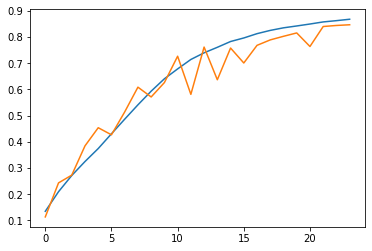

In [0]:
import matplotlib.pyplot as plt

#Accuracy Plot
plt.plot(Train_Acc)
plt.plot(Test_Acc)

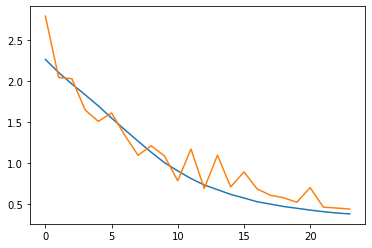

In [0]:
#Loss Plot

plt.plot(Train_Loss)
plt.plot(Test_Loss)